In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from glob import glob
import multiprocessing
import pickle

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
data = pd.read_csv('../data/public_data/train.csv')
data = data.drop(['요일'], axis=1)
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.set_index('date', inplace=True)
data.clip(0, inplace=True)

In [4]:
data.head(2)

,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),건고추_거래량(kg),건고추_가격(원/kg),마늘_거래량(kg),마늘_가격(원/kg),...,청상추_거래량(kg),청상추_가격(원/kg),백다다기_거래량(kg),백다다기_가격(원/kg),애호박_거래량(kg),애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-02,80860.0,329.0,80272.0,360.0,122787.5,1281.0,3.0,11000.0,15019.0,5475.0,...,5125.0,9235.0,434.0,2109.0,19159.0,2414.0,880.0,2014.0,0.0,0.0


In [5]:
data.columns

Index(['배추_거래량(kg)', '배추_가격(원/kg)', '무_거래량(kg)', '무_가격(원/kg)', '양파_거래량(kg)',
       '양파_가격(원/kg)', '건고추_거래량(kg)', '건고추_가격(원/kg)', '마늘_거래량(kg)',
       '마늘_가격(원/kg)', '대파_거래량(kg)', '대파_가격(원/kg)', '얼갈이배추_거래량(kg)',
       '얼갈이배추_가격(원/kg)', '양배추_거래량(kg)', '양배추_가격(원/kg)', '깻잎_거래량(kg)',
       '깻잎_가격(원/kg)', '시금치_거래량(kg)', '시금치_가격(원/kg)', '미나리_거래량(kg)',
       '미나리_가격(원/kg)', '당근_거래량(kg)', '당근_가격(원/kg)', '파프리카_거래량(kg)',
       '파프리카_가격(원/kg)', '새송이_거래량(kg)', '새송이_가격(원/kg)', '팽이버섯_거래량(kg)',
       '팽이버섯_가격(원/kg)', '토마토_거래량(kg)', '토마토_가격(원/kg)', '청상추_거래량(kg)',
       '청상추_가격(원/kg)', '백다다기_거래량(kg)', '백다다기_가격(원/kg)', '애호박_거래량(kg)',
       '애호박_가격(원/kg)', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)', '샤인마스캇_거래량(kg)',
       '샤인마스캇_가격(원/kg)'],
      dtype='object')

In [6]:
unique_pum = [
        '배추', '무', '양파', '건고추','마늘',
        '대파', '얼갈이배추', '양배추', '깻잎',
        '시금치', '미나리', '당근',
        '파프리카', '새송이', '팽이버섯', '토마토',
    ]

In [7]:
unique_kind = [
        '청상추', '백다다기', '애호박', '캠벨얼리', '샤인마스캇'
    ]

In [8]:
def make_df(all_data, target):
    data1 = all_data[['{}_거래량(kg)'.format(target), '{}_가격(원/kg)'.format(target)]]

    data1.columns = ['amonut', 'price']

    data1['year'] = data1.index.year
    data1['month'] = data1.index.month
    data1['day'] = data1.index.day
    data1['week'] = data1.index.weekday

    temp1 = pd.get_dummies(data1['week'])

    data2 = data1.copy()

    data2 = data2.reset_index().merge(temp1.reset_index(), on='date').set_index('date')
    data2 = data2.drop(['week'], axis=1)
    return data2

In [9]:
def get_train(train_data):
    
    train_X = train_data[feature_cols].values
    train_y = train_data[y_col].values

    return train_X, train_y

In [10]:
dt_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='1d')

In [11]:
vali_day = [4, 7]
test_day = [2, 5]

In [12]:
feature_cols = ['year', 'month', 'day', 0, 1, 2, 3, 4, 5, 6]
y_col = ['price']

In [14]:
def make_model(all_data, target):
    
    md_data = make_df(all_data, target)

    day = md_data.index.day % 10

    train_data = md_data[(~day.isin(vali_day))&(~day.isin(test_day))]
    train_X, train_y = get_train(md_data)

    np.random.seed(1)
    idx = np.arange(train_X.shape[0])
    np.random.shuffle(idx)

    _train_X = train_X[idx, :]
    _train_y = train_y[idx, :]

    params = {
        'loss': 'huber',
        'learning_rate': 0.1,
        'n_estimators': 300,
        'subsample': 1.0,
        'min_samples_split': 3,
        'min_samples_leaf': 2,
        'max_depth': 3,
        'alpha': 0.9,
    }
    gab_model = make_pipeline(
        StandardScaler(),
        GradientBoostingRegressor(**params)
    )

    gab_model.fit(_train_X, _train_y)

    with open('model/bo_model_{}.pkl'.format(target), 'wb') as f:
        pickle.dump(gab_model, f)

In [15]:
for target in unique_pum:
    make_model(data, target)

# predict

In [22]:
md_data = make_df(data, target)

day = md_data.index.day % 10

vali_data = md_data[(day.isin(vali_day))]

In [23]:

with open('model/bo_model_{}.pkl'.format(unique_pum[0]), 'rb') as f:
    gab_model = pickle.load(f)

pred = gab_model.predict(vali_data[feature_cols])

vali_data['pred'] = pred

In [24]:
plt.rcParams["figure.figsize"] = (5,5)

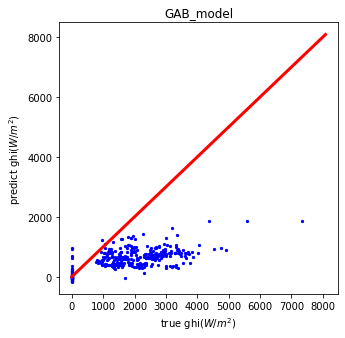

In [26]:
y = vali_data['pred']
x = vali_data['price']

ymax = max(x.max(), y.max())*1.1

fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, s=5, color='blue', alpha=1)
ax.set_ylabel('predict ghi($W/m^2$)')
ax.set_xlabel('true ghi($W/m^2$)')
ax.plot(np.linspace(0, ymax, 100), np.linspace(0, ymax, 100), 
        linewidth=3, color='red')
#ax.legend()
ax.title.set_text('GAB_model')